In [1]:
# Without suppressing message, there is a big pink block which kills readability
suppressMessages({
library(ggplot2)
library(rethinking)
library(mlbench)
library(tidyverse)
library(GGally)
    })

# Linear Regression (with quap)
+ Data - [mlbench library Boston Housing Dataset](http://math.furman.edu/~dcs/courses/math47/R/library/mlbench/html/BostonHousing.html)
+ Reference Kaggle Analysis Notebooks
    + https://www.kaggle.com/code/prasadperera/the-boston-housing-dataset
    + https://www.kaggle.com/code/tolgahancepel/boston-housing-regression-analysis

Description

Housing data for 506 census tracts of Boston from the 1970 census. The dataframe BostonHousing contains the original data by Harrison and Rubinfeld (1979), the dataframe BostonHousing2 the corrected version with additional spatial information (see references below). 

The original data are 506 observations on 14 variables, medv being the target variable:
+ **crim** 	per capita crime rate by town
+ **zn** 	proportion of residential land zoned for lots over 25,000 sq.ft
+ **indu**s 	proportion of non-retail business acres per town
+ **chas** 	Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
+ **nox** 	nitric oxides concentration (parts per 10 million)
+ **rm** 	average number of rooms per dwelling
+ **age** 	proportion of owner-occupied units built prior to 1940
+ **dis** 	weighted distances to five Boston employment centres
+ **rad** 	index of accessibility to radial highways
+ **tax** 	full-value property-tax rate per USD 10,000
+ **ptratio** 	pupil-teacher ratio by town
+ **b** 	1000(B - 0.63)^2 where B is the proportion of blacks by town
+ **lstat** 	percentage of lower status of the population
+ **medv** 	median value of owner-occupied homes in USD 1000's

The corrected data set has the following additional columns:
+ **cmedv** 	corrected median value of owner-occupied homes in USD 1000's
+ **town** 	name of town
+ **tract** 	census tract
+ **lon** 	longitude of census tract
+ **lat** 	latitude of census tract 

# Data

In [2]:
data(BostonHousing2)
# data(milk)
d <- as_tibble(BostonHousing2)
d <- d[, c("crim", 'zn', "town", "chas", "rm", "lstat", "cmedv")]
d <- d %>% 
  rename(
    crime_rate = crim,
    perc_zoned_25k = zn,
    adj_river = chas,
    mean_rooms = rm,
    perc_lower_status = lstat,
    median_price = cmedv    
    )
d <- data.frame(d)
str(d)
head(d)

'data.frame':	506 obs. of  7 variables:
 $ crime_rate       : num  0.00632 0.02731 0.02729 0.03237 0.06905 ...
 $ perc_zoned_25k   : num  18 0 0 0 0 0 12.5 12.5 12.5 12.5 ...
 $ town             : Factor w/ 92 levels "Arlington","Ashland",..: 54 77 77 46 46 46 69 69 69 69 ...
 $ adj_river        : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ mean_rooms       : num  6.58 6.42 7.18 7 7.15 ...
 $ perc_lower_status: num  4.98 9.14 4.03 2.94 5.33 ...
 $ median_price     : num  24 21.6 34.7 33.4 36.2 28.7 22.9 22.1 16.5 18.9 ...


,crime_rate,perc_zoned_25k,town,adj_river,mean_rooms,perc_lower_status,median_price
,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
1,0.00632,18,Nahant,0,6.575,4.98,24.0
2,0.02731,0,Swampscott,0,6.421,9.14,21.6
3,0.02729,0,Swampscott,0,7.185,4.03,34.7
4,0.03237,0,Marblehead,0,6.998,2.94,33.4
5,0.06905,0,Marblehead,0,7.147,5.33,36.2
6,0.02985,0,Marblehead,0,6.430,5.21,28.7


# Data Review
## Continuous Variables 

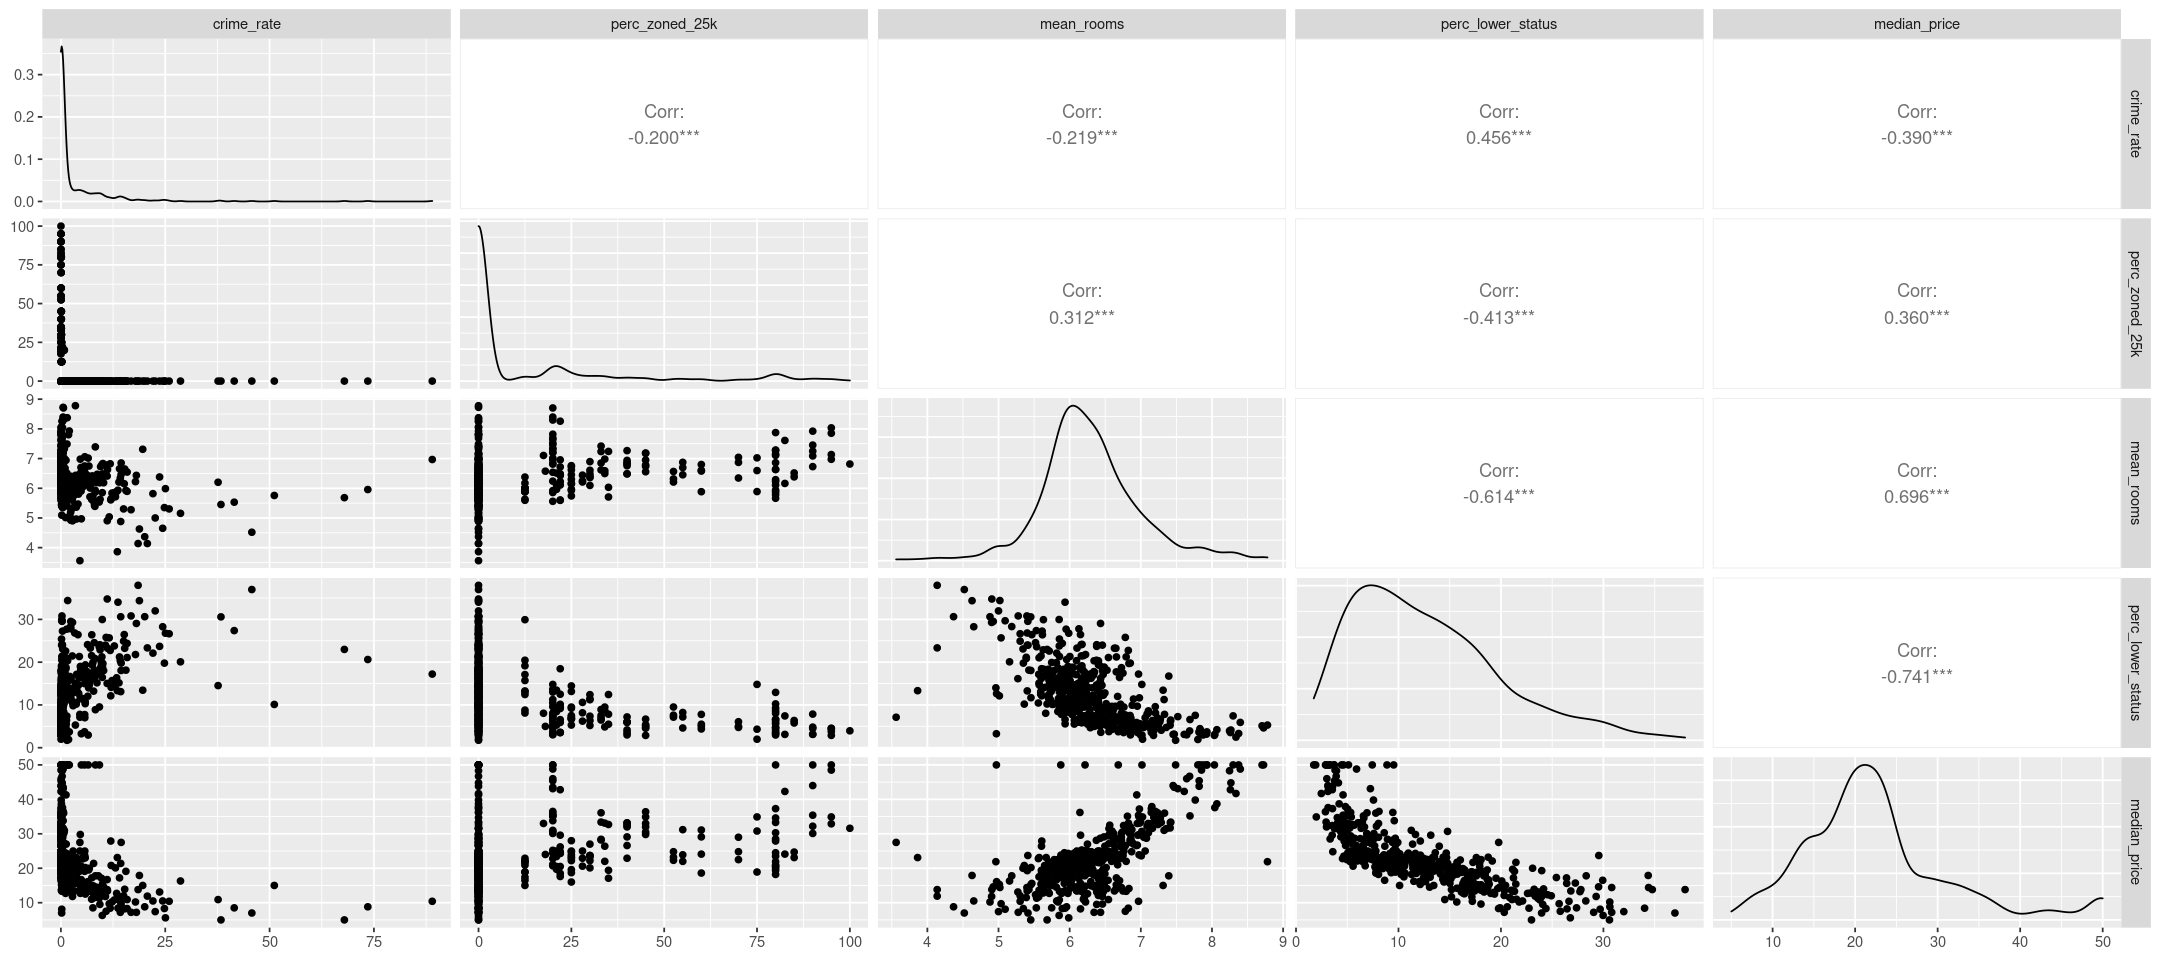

In [3]:
options(repr.plot.width=18, repr.plot.height=8)
ggpairs(d, columns=c("crime_rate", "perc_zoned_25k", "mean_rooms", "perc_lower_status", "median_price"))

## Categorical Variables

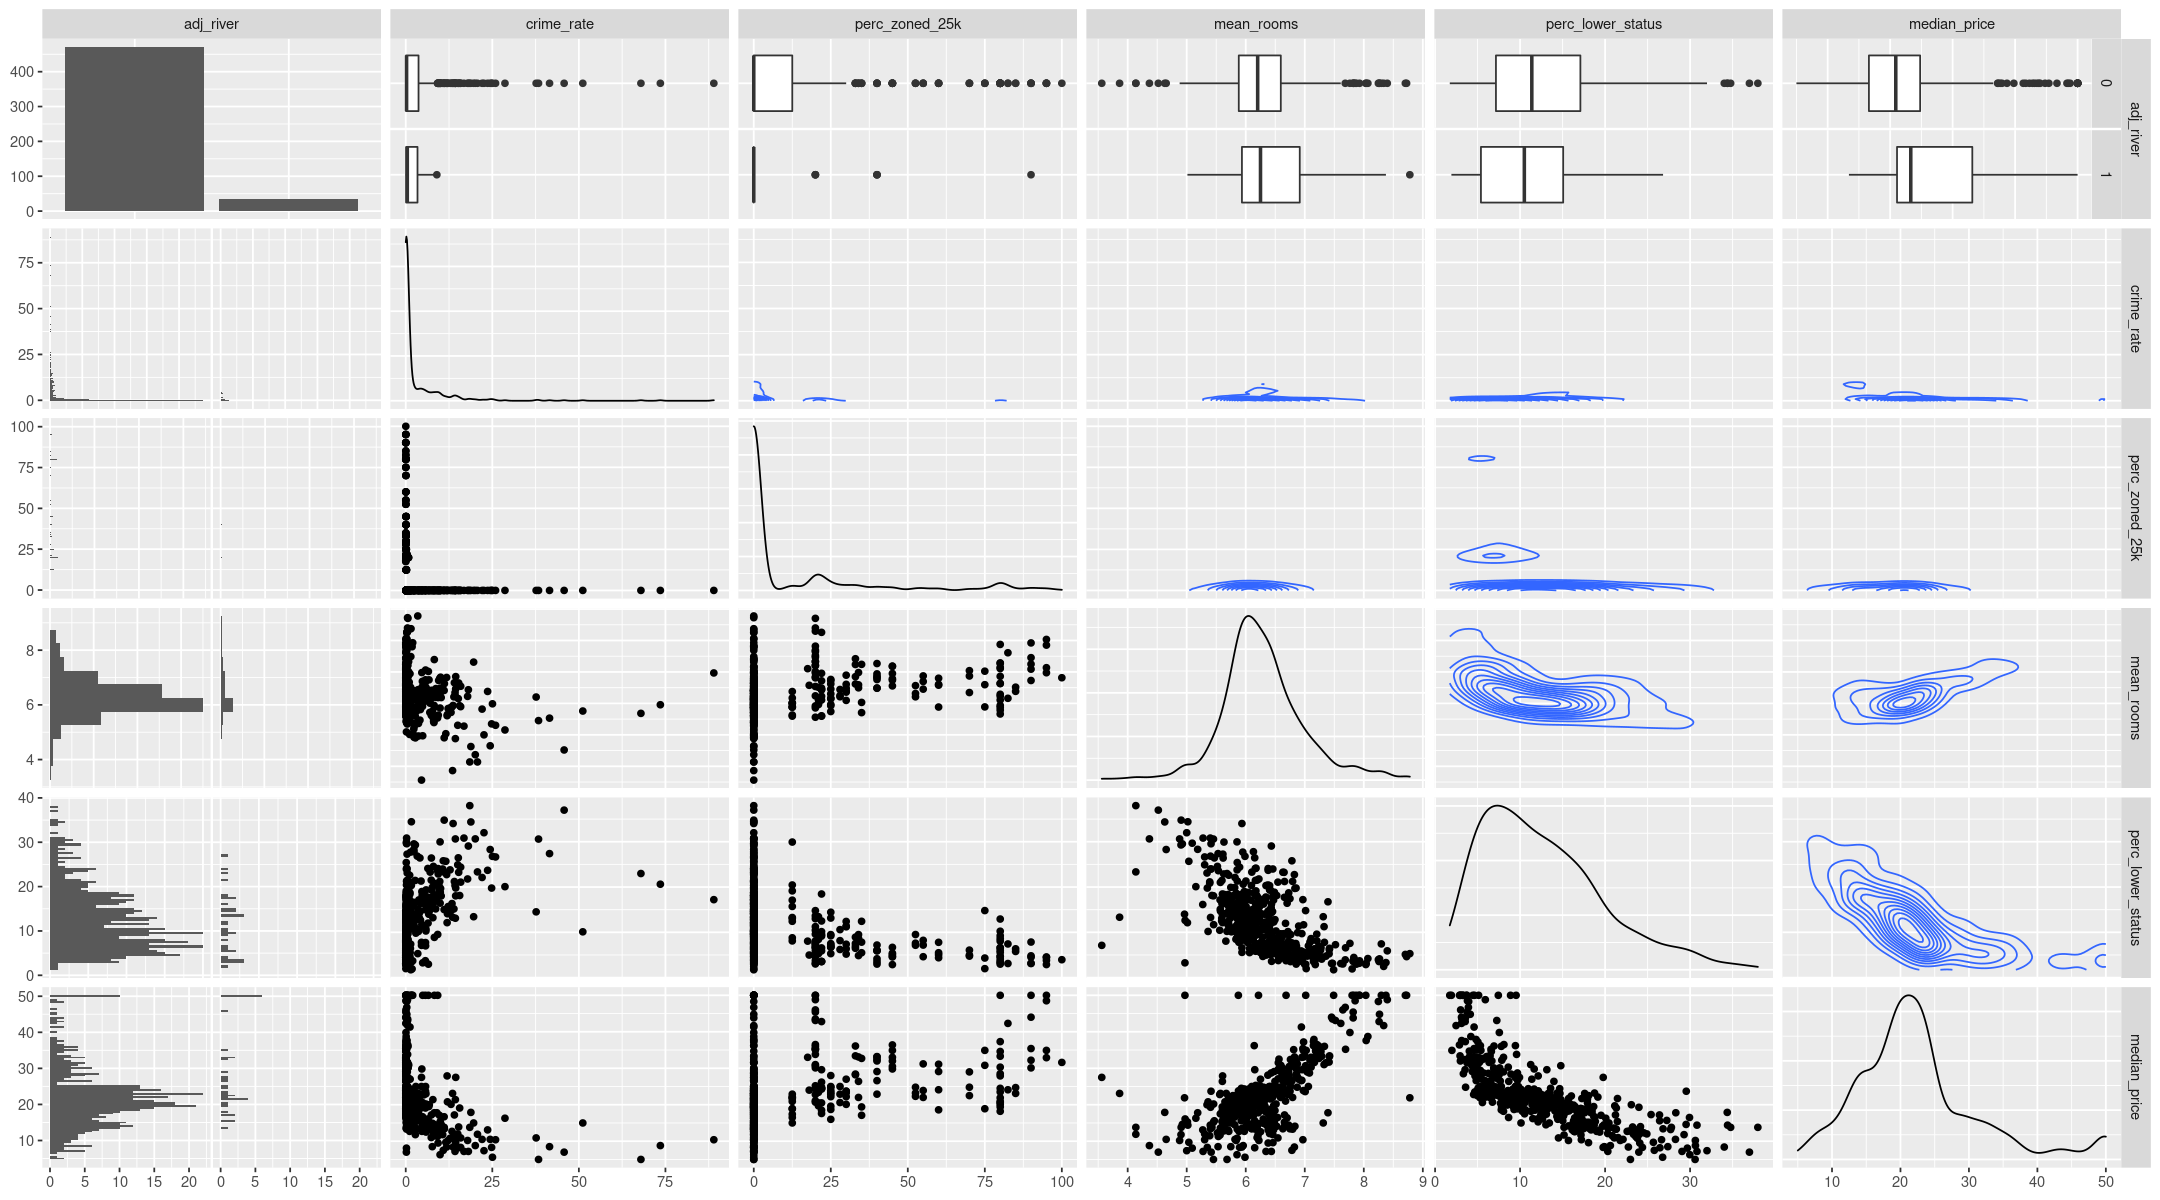

In [4]:
# Only want the top row of this
# want to do the same for the towns
# The plot text is so small it is nearly unreadable. Investigate fontsize
options(repr.plot.width=18, repr.plot.height=10)
ggpairs(d, columns=c("adj_river", "crime_rate", "perc_zoned_25k", "mean_rooms", "perc_lower_status", "median_price"),
        upper=list(continuous="density", combo="box"),
       lower=list(combo=wrap("facethist", binwidth=0.5)))

## Continuous variables - Standardized & Standardized Log of Value

In [5]:
d$crime_rate_std <- scale(d$crime_rate)
d$perc_zoned_25k_std <- scale(d$perc_zoned_25k)
d$num_rooms_std <- scale(d$mean_rooms)
d$perc_lower_status_std <- scale(d$perc_lower_status)
d$price_logstd <- scale(log(d$median_price)) 
str(d)

'data.frame':	506 obs. of  12 variables:
 $ crime_rate           : num  0.00632 0.02731 0.02729 0.03237 0.06905 ...
 $ perc_zoned_25k       : num  18 0 0 0 0 0 12.5 12.5 12.5 12.5 ...
 $ town                 : Factor w/ 92 levels "Arlington","Ashland",..: 54 77 77 46 46 46 69 69 69 69 ...
 $ adj_river            : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ mean_rooms           : num  6.58 6.42 7.18 7 7.15 ...
 $ perc_lower_status    : num  4.98 9.14 4.03 2.94 5.33 ...
 $ median_price         : num  24 21.6 34.7 33.4 36.2 28.7 22.9 22.1 16.5 18.9 ...
 $ crime_rate_std       : num [1:506, 1] -0.419 -0.417 -0.417 -0.416 -0.412 ...
  ..- attr(*, "scaled:center")= num 3.61
  ..- attr(*, "scaled:scale")= num 8.6
 $ perc_zoned_25k_std   : num [1:506, 1] 0.285 -0.487 -0.487 -0.487 -0.487 ...
  ..- attr(*, "scaled:center")= num 11.4
  ..- attr(*, "scaled:scale")= num 23.3
 $ num_rooms_std        : num [1:506, 1] 0.413 0.194 1.281 1.015 1.227 ...
  ..- attr(*, "scaled:center")= num 6

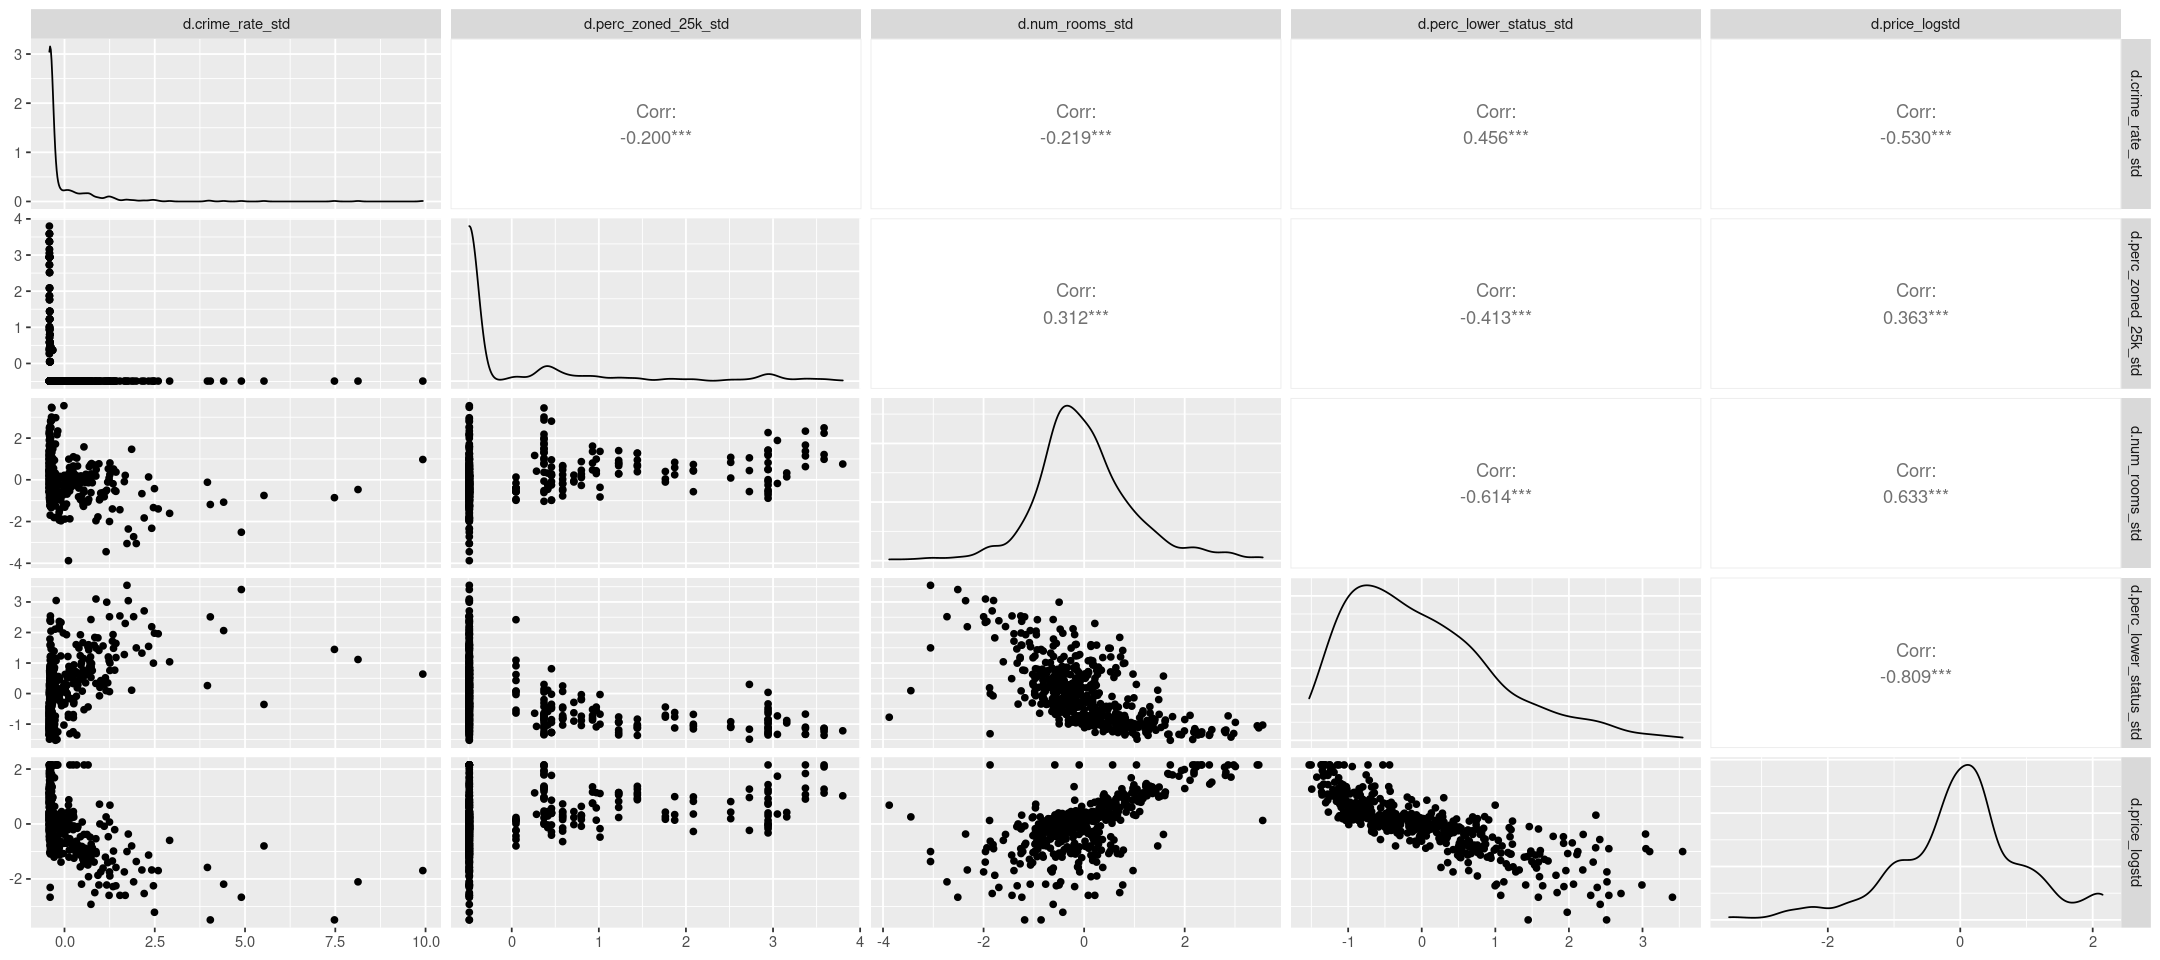

In [6]:
options(repr.plot.width=18, repr.plot.height=8)
# ggpairs(d, columns=c("crime_rate_std", "perc_zoned_25k_std", "num_rooms_std", "perc_lower_status_std", "price_logstd"))
# ggpairs(data.frame(d), columns=c("crime_rate_std", "perc_zoned_25k_std")) # ", "num_rooms_std", "perc_lower_status_std", "price_logstd"))
ggpairs(data.frame(d$crime_rate_std, d$perc_zoned_25k_std, d$num_rooms_std, d$perc_lower_status_std, d$price_logstd))

# 1.0 Single Variable Linear Regression - Mean Number of Rooms vs Price
    
+ The model - Data is standardized/scaled? - made to look close to normally distributed
    + $price_i \sim Normal(\mu_i, \sigma)$ [likelihood]
    + $u_i = \alpha + \beta_r(num\_rooms_i - \bar{num\_rooms})$ [linear model is: mu_i = alpha + beta_r(num_rooms_i - mean_num_rooms)]
    + $\alpha \sim Normal(0, 0.2)$ [alpha prior]
    + $\beta_r \sim Normal(0, 0.5)$ [beta prior]
    + $\sigma \sim Exponential(1)$ [sigma prior]

## 1.1 Plot the Data 

'data.frame':	506 obs. of  2 variables:
 $ num_rooms_std: num [1:506, 1] 0.413 0.194 1.281 1.015 1.227 ...
  ..- attr(*, "scaled:center")= num 6.28
  ..- attr(*, "scaled:scale")= num 0.703
 $ price_logstd : num [1:506, 1] 0.3515 0.0934 1.2545 1.161 1.3582 ...
  ..- attr(*, "scaled:center")= num 3.03
  ..- attr(*, "scaled:scale")= num 0.408


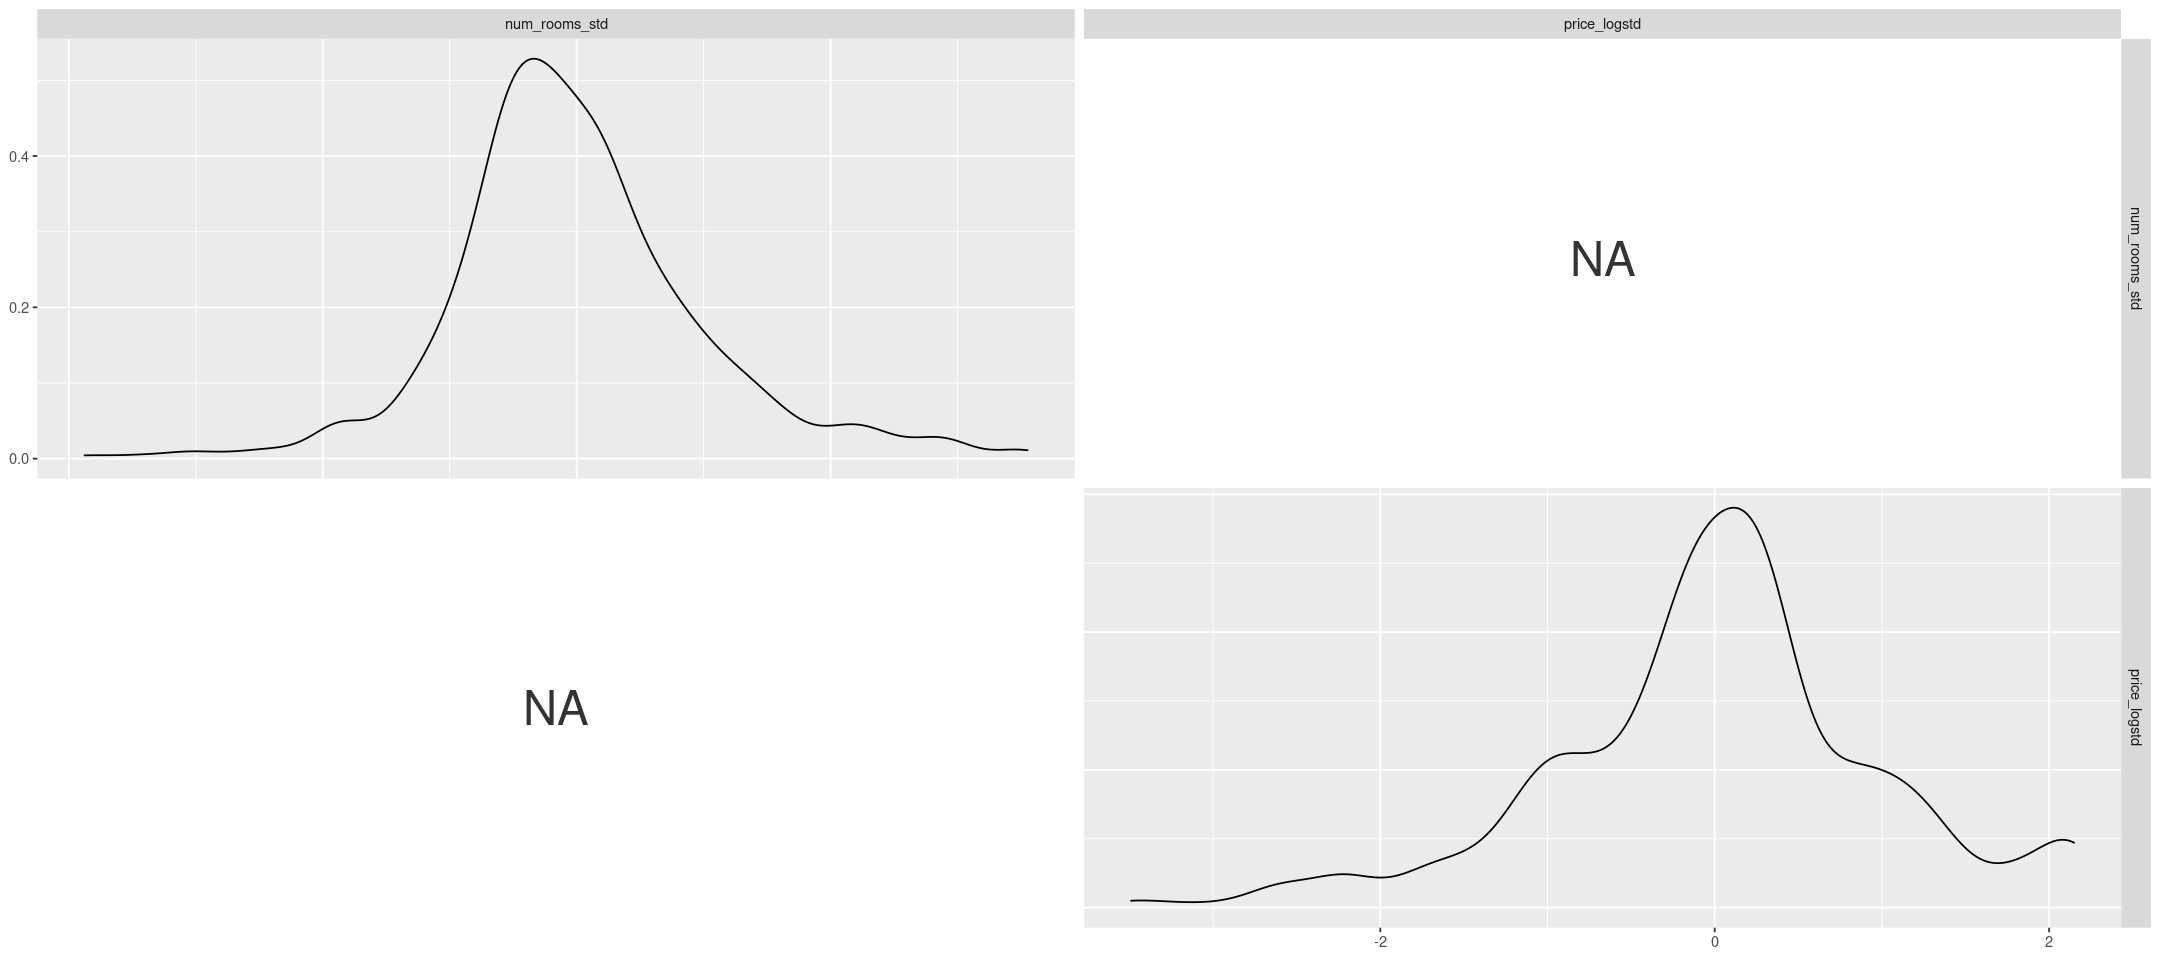

In [7]:
options(repr.plot.width=18, repr.plot.height=8)
# ggpairs(d, columns=c("crime_rate_std", "perc_zoned_25k_std", "num_rooms_std", "perc_lower_status_std", "price_logstd"))
df = data.frame(d[, c("num_rooms_std", "price_logstd")])
str(df)
ggpairs(df)

# Why does the pairs plot lose the correlation data for standardized data?

## 1.2 Define the Model

In [8]:
# str(df)

In [9]:
# Try renaming the variables just in case McElreath's code cannot deal with . and/or _ in a variable name
df <- df %>% 
  rename(
    numRooms = num_rooms_std,
    priceLogStd = price_logstd    
    )

In [10]:
# str(df)

+ The model as maths
    + $price_i \sim Normal(\mu_i, \sigma)$ [likelihood]
    + $u_i = \alpha + \beta_r(num\_rooms_i - \bar{num\_rooms})$ [linear model is: mu_i = alpha + beta_r(num_rooms_i - mean_num_rooms)]
    + $\alpha \sim Normal(0, 0.33)$ [alpha prior] - stdev lifted from 0.2 to 0.33 so 3 sigma covers 1 unit instead of 0.6 units
    + $\beta_r \sim Normal(0, 0.5)$ [beta prior]
    + $\sigma \sim Exponential(1)$ [sigma prior]

In [11]:
# Model as Code
m1.0 <- quap(
    alist(
        priceLogStd ~ dnorm(mu, sigma), # likelihood
        mu <- a + br * numRooms, # linear model
        a ~ dnorm( 0, 0.33), # alpha prior
        br ~ dnorm(0, 0.5), # beta prior
        sigma ~ dexp(1) # sigma prior
    ), data=df)

In [12]:
# plot(precis(m1.0))

## 1.3 Simulate Priors & Review for Validity

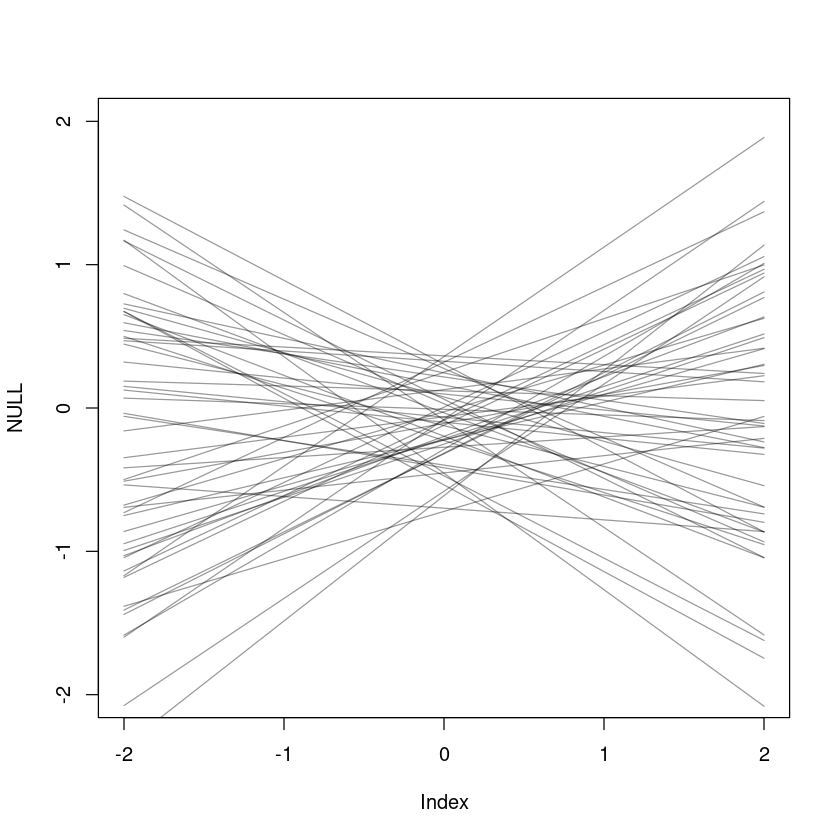

In [13]:
options(repr.plot.width=7, repr.plot.height=7)
set.seed(10)
prior <- extract.prior(m1.0)
mu <- link(m1.0, post=prior, data=list(numRooms=c(-2,2)))
plot(NULL, xlim=c(-2, 2), ylim=c(-2,2))
for ( i in 1:50) lines(c(-2,2), mu[i,], col=col.alpha("black", 0.4))

## 1.5 Plot Posterior Distributions

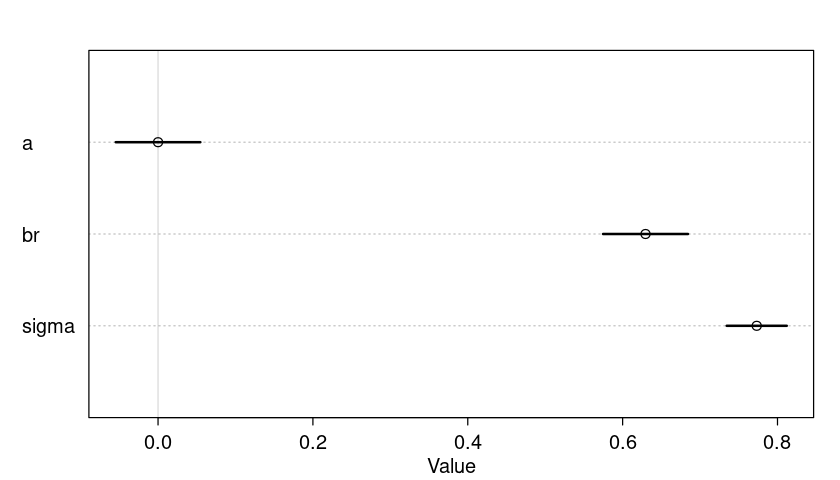

In [14]:
options(repr.plot.width=7, repr.plot.height=4)
plot(precis(m1.0))

## 1.6 Plot Model and Data

In [15]:
# compute percentile interval of mean
A_seq <- seq(from=-3, to=3.2, length.out=30)
mu <- link(m1.0, data=list(numRooms=A_seq))
mu.mean <- apply(mu, 2, mean)
mu.PI <- apply(mu, 2, PI)

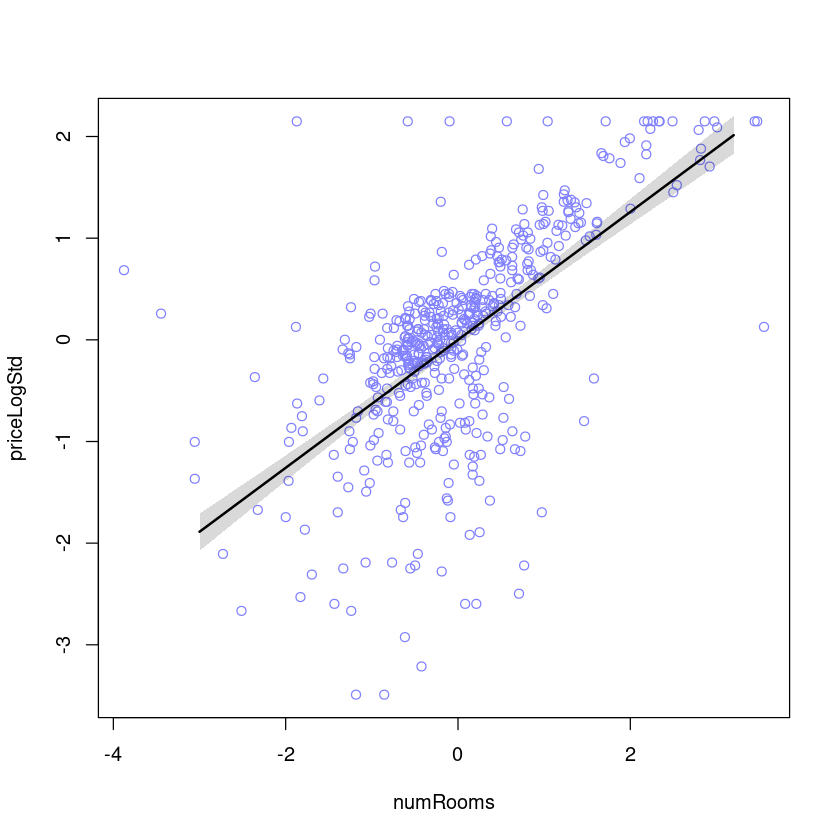

In [16]:
options(repr.plot.width=7, repr.plot.height=7)
plot(priceLogStd ~ numRooms, data=df, col=rangi2)
lines(A_seq, mu.mean, lwd=2)
shade(mu.PI, A_seq)

## Now I am a bit confused
+ I want to plot prediction intervals as per Chapter 4
+ But I want the data de-standardized, so I am working in number of rooms and $
+ Not sure what to do - Will consider
+ Also, not sure if I should have used (num_rooms - mean_num_rooms) in the linear model
    + Author uses one technique in chapter 4 and a different technique in chapter 5


## 1.6 Plot Prediction Intervals
+ The code below was from the height vs weight data in chapter 4, but my model is setup differently

In [17]:
# Original Book Code

# mu.mean <- apply(mu, 2, mean)
# mu.PI <- apply(mu, 2, PI, prob=0.89)
# # Plot data
# plot( height ~ weight , data=d2 , col=col.alpha(rangi2,0.5) )
# # Plot mean regression line
# lines( weight.seq , mu.mean )
# # Shade the PI
# shade( mu.PI , weight.seq )

# weight.seq <- seq(from=25, to=70, by=1)
# sim.height <- sim(m4.3, data=list(weight=weight.seq))
# str(sim.height)

# Code adapted
mu.mean <- apply(mu, 2, mean)
mu.PI <- apply(mu, 2, PI, prob=0.89)
numRooms.seq <- seq(from=-4.0, to=4.0, by=0.13)
sim.priceLogStd <- sim(m1.0, data=list(numRooms=numRooms.seq))
str(sim.priceLogStd)

 num [1:1000, 1:62] -1.809 -3.791 -2.235 -0.958 -3.62 ...


In [18]:
# mu.mean

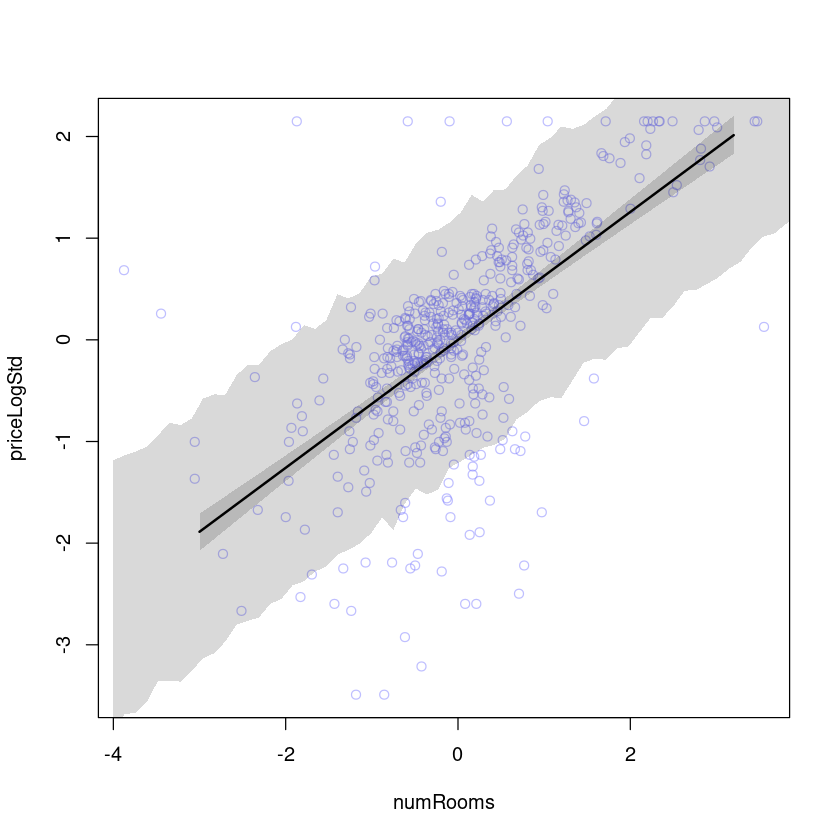

In [19]:
# Original book code
# height.PI <- apply(sim.height, 2, PI, prob=0.89)
# plot( height ~ weight , d2 , col=col.alpha(rangi2,0.5) )
# lines( weight.seq , mu.mean )
# shade( mu.PI , weight.seq ) - # Code error mu.HDPI in book
# shade( height.PI , weight.seq )

# code adapted
priceLogStd.PI <- apply(sim.priceLogStd, 2, PI, prob=0.89)
plot( priceLogStd ~ numRooms , df , col=col.alpha(rangi2,0.5) )
# lines( numRooms.seq , mu.mean )
lines(A_seq, mu.mean, lwd=2)
# shade( mu.PI , priceLogStd.seq ) - # Code error mu.HDPI in book
shade(mu.PI, A_seq)
shade( priceLogStd.PI , numRooms.seq )

+ This plot looks OK, but I want to be able to select a number of rooms, say 5, and get an estimate of minimum and maximum price for the property

In [20]:
# numRooms.seq

In [21]:
help(link)

link-methods {rethinking},R Documentation
fit,Object of class map or map2stan
data,"Optional list of data to compute predictions over. When missing, uses data found inside fit object."
n,Number of samples to use
post,"Optional samples from posterior. When missing, link extracts the samples using extract.samples."
refresh,Refresh interval for progress display. Set to refresh=0 to suppress display.
replace,Optional named list of samples to replace inside posterior samples. See examples.
flatten,"When TRUE, removes linear model names from result"
...,Other parameters to pass to someone


In [22]:
stop

function (..., call. = TRUE, domain = NULL) 
{
    if (...length() == 1L && inherits(..1, "condition")) {
        cond <- ..1
        if (nargs() > 1L) 
            warning("additional arguments ignored in stop()")
        message <- conditionMessage(cond)
        call <- conditionCall(cond)
        .Internal(.signalCondition(cond, message, call))
        .Internal(.dfltStop(message, call))
    }
    else .Internal(stop(call., .makeMessage(..., domain = domain)))
}
<bytecode: 0x55ab9fce4418>
<environment: namespace:base>

In [23]:
help(ggpairs)

ggpairs {GGally},R Documentation
data,data set using. Can have both numerical and categorical data.
mapping,"aesthetic mapping (besides x and y). See aes(). If mapping is numeric, columns will be set to the mapping value and mapping will be set to NULL."
columns,which columns are used to make plots. Defaults to all columns.
"title, xlab, ylab","title, x label, and y label for the graph"
upper,see Details
lower,see Details
diag,see Details
params,deprecated. Please see wrap_fn_with_param_arg
...,deprecated. Please use mapping
axisLabels,"either ""show"" to display axisLabels, ""internal"" for labels in the diagonal plots, or ""none"" for no axis labels"
